In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('F:/innomatics/sentiment_analysis_project/reviews_data_dump/labeled_sentiment_flipkart_reviews.csv')

In [3]:
df.head()

,review_text,label
0,"Nice product, good quality, but price is now r...",negative
1,They didn't supplied Yonex Mavis 350. Outside ...,negative
2,Worst product. Damaged shuttlecocks packed in ...,negative
3,"Quite O. K. , but nowadays the quality of the...",negative
4,Over pricedJust â?¹620 ..from retailer.I didn'...,negative


In [4]:
# a negative review

df.loc[0, 'review_text']

'Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.'

In [5]:
# a positve review

df.loc[5, 'review_text']

'Good quality product. Delivered on time.'

In [6]:
# label distribution

df.label.value_counts()

label
positive    6422
negative    1272
neutral      816
Name: count, dtype: int64


As we can see from above that our label is **highly undistributed**, this needs to be considered in future while tuning the models


In [7]:
df = df.loc[df['label'] != 'neutral']

In [8]:
label_map = {'negative': 0, 'positive': 1}
df['label'] = df['label'].map(label_map)

In [9]:
df.head()

,review_text,label
0,"Nice product, good quality, but price is now r...",0
1,They didn't supplied Yonex Mavis 350. Outside ...,0
2,Worst product. Damaged shuttlecocks packed in ...,0
3,"Quite O. K. , but nowadays the quality of the...",0
4,Over pricedJust â?¹620 ..from retailer.I didn'...,0


In [10]:
df.label.value_counts()

label
1    6422
0    1272
Name: count, dtype: int64

In [11]:
#balancing dataframe before any modeling processes

positive_df = df[df['label'] == 1]
negative_df = df[df['label'] == 0]

# Randomly sample the same number of rows from the positive class as there are rows in the negative class
positive_df = positive_df.sample(n=len(negative_df), replace=False, random_state=42)

# Step 3: Concatenate the sampled positive class with the negative class
balanced_df = pd.concat([positive_df, negative_df])

# Shuffle the dataset to randomize the order of rows
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [12]:
df.shape

(2544, 2)

In [13]:
df.label.value_counts()

label
1    1272
0    1272
Name: count, dtype: int64

## Data Modeling and model building

### 1. Identifying Input and outputs

In [14]:
X = df.review_text
y = df.label

print(X.shape, y.shape)

(2544,) (2544,)


### 2. split the data into train and test 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((2035,), (509,))

### 3. Data Preprocessing

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

#on train data
%time X_train_vect = vect.fit_transform(X_train)

feature_names = vect.get_feature_names_out()

CPU times: total: 0 ns
Wall time: 20 ms


In [17]:
feature_names

array(['02', '07', '10', ..., 'yr', 'zero', '¹620'], dtype=object)

In [18]:
#data preprocessing on test data

X_test_vect = vect.transform(X_test)

### 4. Building a model

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=3, random_state=42)

%time clf.fit(X_train_vect, y_train)

CPU times: total: 109 ms
Wall time: 135 ms


RandomForestClassifier(max_depth=3, random_state=42)

### 5. Evaluation of the model

In [20]:
from sklearn import metrics

#evaluation on train data
y_train_pred = clf.predict(X_train_vect)

accuracy = metrics.accuracy_score(y_train, y_train_pred)
f1_score = metrics.f1_score(y_train, y_train_pred)

print(f"accuracy for training data is {accuracy} and f1 score is {f1_score}")

accuracy for training data is 0.8786240786240787 and f1 score is 0.8823249166269653


Text(0.5, 23.52222222222222, 'Predicted')

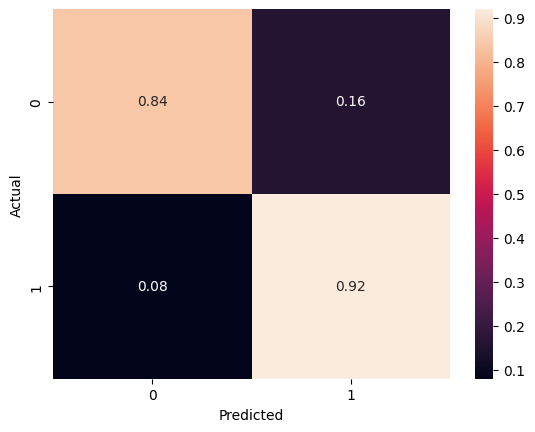

In [21]:
#confusion matrix for train data evaluation

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [22]:
#evaluation on test data
y_test_pred = clf.predict(X_test_vect)

accuracy = metrics.accuracy_score(y_test, y_test_pred)
f1_score = metrics.f1_score(y_test, y_test_pred)

print(f"accuracy for training data is {accuracy} and f1 score is {f1_score}")

accuracy for training data is 0.8801571709233792 and f1 score is 0.8900900900900901


Text(0.5, 23.52222222222222, 'Predicted')

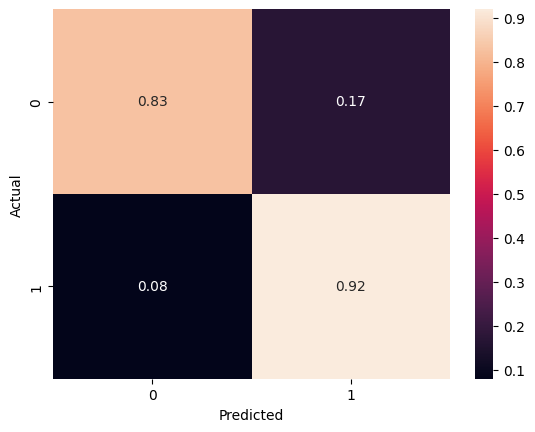

In [23]:
#confusion matrix for test data

cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [24]:
data = ['good product, really happy']
def pred(data=[]):
    
    data_vect = vect.transform(data)
    pred = clf.predict(data_vect)
    return pred

pred(data)

array([1], dtype=int64)

## Implementing pipeline on our dataset

In [25]:
import warnings
warnings.filterwarnings('ignore')


from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

In [26]:
import joblib
import time
from joblib import Memory
import os
import mlflow

In [27]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    
    'random_forest': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', RandomForestClassifier())
    ], memory=memory),
    
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory),
    
    'svm': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', SVC())
    ], memory=memory),

    'knn': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', KNeighborsClassifier())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000], 
            'classifier__alpha' : [0.1, 0.5, 1, 10]
        }
    ],
    'random_forest': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000],
            'classifier__max_depth': [None, 5, 10],
            'classifier__n_estimators': [100, 200, 300]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 2000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['l1', 'l2'], 
            'classifier__solver': ['liblinear', 'saga'],
        }
    ],
    'knn': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000], 
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__p': [1, 2]
        }
    ],
    'svm': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000], 
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__gamma': ['scale', 'auto']
        }
    ],
}

In [28]:
mlflow.set_experiment('flipkart-sentiment-analysis')

<Experiment: artifact_location='file:///F:/innomatics/sentiment_analysis_project/jupyter_model_train/mlruns/719227907250715711', creation_time=1711468250097, experiment_id='719227907250715711', last_update_time=1711468250097, lifecycle_stage='active', name='flipkart-sentiment-analysis', tags={}>

In [29]:
# Perform GridSearchCV for each algorithm and log in the mlflow
dev = 'Ishaq Miyawala'
best_models = {}


for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    clf = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=3, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )

    #autologging
    mlflow.sklearn.autolog(max_tuning_runs=None)
    
    with mlflow.start_run() as run:
        %time clf.fit(X_train, y_train)
        
    print('Train Score: ', clf.best_score_)
    print('Test Score: ', clf.score(X_test, y_test))

    best_models[algo] = clf.best_estimator_
    print()


    # #custom logging
    # #fit the data on the model and calculate time
    # start_fit_time = time.time()
    # clf.fit(X_train, y_train)
    # end_fit_time = time.time()

    # #prediction time
    # start_predict_time = time.time()
    # y_pred = clf.predict(X_test)
    # end_predict_time = time.time()

    # #save the best models for each algorithm
    # joblib.dump(clf.best_estimator_, f'best_models/{name}.pkl')
    # model_size = os.path.getsize(f'best_models/{algo}.pkl')

    #  # Printing Log
    # print('Train Score: ', clf.best_score_)
    # print('Test Score: ', clf.score(X_test, y_test))
    # print("Fit Time: ", end_fit_time - start_fit_time)
    # print("Predict Time: ", end_predict_time - start_predict_time)
    # print("Model Size: ", model_size)
    # print()

    # #MLflow experiment run
    # with mlflow.start_run() as run:
        
    #     # Log tags
    #     mlflow.set_tag("developer", dev)

    #     # Log Parameters 
    #     mlflow.log_param("algorithm", algo)
    #     mlflow.log_param("hyperparameter_grid", param_grids[algo])
    #     mlflow.log_param("best_hyperparameter", clf.best_params_)

    #     # Log Metrics 
    #     mlflow.log_metric("train_score", clf.best_score_)
    #     mlflow.log_metric("test_score", clf.score(X_test, y_test))
    #     mlflow.log_metric("fit_time", end_fit_time - start_fit_time)
    #     mlflow.log_metric("predict_time", end_predict_time - start_predict_time)
    #     mlflow.log_metric("model_size", model_size)

    #     # Log Model
    #     mlflow.sklearn.log_model(clf.best_estimator_, f"{algo}_model")
    

********** naive_bayes **********


2024/03/27 13:22:07 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 12 candidates, totalling 36 fits


2024/03/27 13:22:25 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 2.58 s
Wall time: 18.1 s
Train Score:  0.935811460348912
Test Score:  0.9104761904761903

********** random_forest **********
Fitting 3 folds for each of 27 candidates, totalling 81 fits
CPU times: total: 1min 9s
Wall time: 1min 56s
Train Score:  0.9435041175208063
Test Score:  0.96045197740113

********** logistic_regression **********


2024/03/27 13:24:22 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 48 candidates, totalling 144 fits
CPU times: total: 8.77 s
Wall time: 21.3 s
Train Score:  0.9628536688086612
Test Score:  0.9586466165413534

********** svm **********


2024/03/27 13:24:43 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


Fitting 3 folds for each of 36 candidates, totalling 108 fits


2024/03/27 13:25:10 WARNING mlflow.sklearn: Unrecognized dataset type <class 'pandas.core.series.Series'>. Dataset logging skipped.


CPU times: total: 14.9 s
Wall time: 26 s
Train Score:  0.962597438813436
Test Score:  0.9589552238805971

********** knn **********
Fitting 3 folds for each of 18 candidates, totalling 54 fits
CPU times: total: 19.7 s
Wall time: 19.6 s
Train Score:  0.8976824119371388
Test Score:  0.903114186851211



In [30]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', MultinomialNB(alpha=0.1))])

random_forest
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', RandomForestClassifier())])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=2000)),
                ('classifier', LogisticRegression(C=10, solver='liblinear'))])

svm
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', SVC(C=1, kernel='linear'))])

knn
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', KNeighborsClassifier(n_neighbors=3, p=1))])



In [31]:
directory = 'best_models'
if not os.path.exists(directory):
    os.makedirs(directory)


for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    %time y_test_pred = model.predict(X_test)
    print("Test Score (F1)", metrics.f1_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

********** naive_bayes **********
CPU times: total: 0 ns
Wall time: 3.97 ms
Test Score (F1) 0.9104761904761903
Model Size: 87463 Bytes
********** random_forest **********
CPU times: total: 31.2 ms
Wall time: 36 ms
Test Score (F1) 0.96045197740113
Model Size: 6221617 Bytes
********** logistic_regression **********
CPU times: total: 0 ns
Wall time: 4 ms
Test Score (F1) 0.9586466165413534
Model Size: 55718 Bytes
********** svm **********
CPU times: total: 15.6 ms
Wall time: 12 ms
Test Score (F1) 0.9589552238805971
Model Size: 83238 Bytes
********** knn **********
CPU times: total: 109 ms
Wall time: 58 ms
Test Score (F1) 0.903114186851211
Model Size: 220956 Bytes


Thus svm provides the most accurate test predictions with minimal predict time too

In [32]:
#using svm model to predict on new data

model = joblib.load('best_models/svm.pkl')

data = ['This product is really good we will definitely buy it in the future']

prediction = model.predict(data)
print('prediction: ',prediction)

#prediction 0 means negative sentiment and 1 means positive sentiment

prediction:  [1]


In [33]:
data2 = ["this is the worst product, won't recommend anyone"]

prediction = model.predict(data2)
print('prediction: ',prediction)

prediction:  [0]


In [41]:
mlflow.sklearn.autolog(disable=True)

****
## Getting it all together and making an ML model workflow
****
**The Three Main components that we will be Using for making a production ready workflow are:**

**1. **Pipeline**
2. **Mlflow**
3. **Prefect****

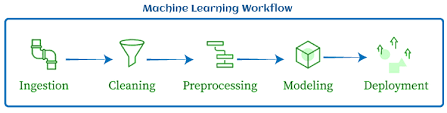

Let's see in detail how these 3 can work together for our problem statement and how we can utilize them for modularity, reproducibility, management, deployment and maintainence of our model.

**1. Pipeline:** A sequence of data transformers with an optional final predictor. Pipeline allows you to sequentially apply a list of transformers to preprocess the data and, if desired, conclude the sequence with a final predictor for predictive modeling. i.e. the stages in which an data is moved through the various segments of the ML model building processes.

**2. MLflow:** MLflow is an open source MLOps tool that can help with the machine learning lifecycle, including training, tuning, and deploying models. some of its advantages are:

    * Streamlined Experiment Tracking and Reproducibility.
    * Enhanced Collaboration and Knowledge Sharing.
    * Improved Model Packaging and Deployment.
    * Efficient Model Lifecycle Management. 

**3. Prefect:** It is is an orchestration tool designed for managing, scheduling, running, and monitoring tasks within a workflow.

### let's train our data for sentiment analysis by logging via MLflow and Prefect
****

**As we have concluded during experimentation phase that Logistic Regression gives a good model for our problem statement, we will be using logistic regression for productionizing and scheduling**

best LR hyperparamters:

{'vectorization': CountVectorizer(), 
'vectorization__max_features': 1000,
'classifier__C': 10, 
'classifier__penalty': 'l2', 
'classifier__solver': 'saga', }

In [42]:
#let's first experiment to find out the best model for our statement and then use prefect for scheduled training

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


import joblib
import time
from joblib import Memory

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import GridSearchCV

In [43]:
from prefect import flow, task

In [47]:
@task
def load_data(csv_path):
    '''
    Given a path this function loads the data from csv in a pandas dataframe.
    '''
    df = pd.read_csv(path)
    df = df.loc[df['label'] != 'neutral']
    label_map = {'negative': 0, 'positive': 1}
    df['label'] = df['label'].map(label_map)
    return df



@task
def separate_inputs_outputs(data, inputs, outputs):
    '''
    separate the inputs and outputs from the data
    '''

    X = data[inputs]
    y = data[outputs]

    return X, y



@task
def split_train_test(X, y, test_size=0.25, random_state=42):
    '''
    splits the training and test data from inputs and outputs
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test



@task
def train_lr_model(X_train, y_train, **hyperparameters):

    cachedir = '.cache'
    memory = Memory(location=cachedir, verbose=0)
    
    pipe = Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory)

    clf = GridSearchCV(estimator=pipe, 
                               param_grid=hyperparameters, 
                               cv=3, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )

    clf.fit(X_train, y_train)
    return clf



@task
def evaluate_lr_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluating the model.
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

        
    train_score = metrics.f1_score(y_train, y_train_pred)
    test_score = metrics.f1_score(y_test, y_test_pred)
    
    return train_score, test_score

In [45]:
@flow(name="LR Training flow", version="flow-1-LR")
def workflow(datapath):
    DATA_PATH = datapath
    INPUT = 'review_text'
    OUTPUT = 'label'
    HYPERPARAMETERS = {'vectorization': [CountVectorizer()], 
                       'vectorization__max_features': [1000], 
                       'classifier__C': [10], 
                       'classifier__penalty': ['l2'], 
                       'classifier__solver': ['saga'], }

    #load data
    data = load_data(DATA_PATH)

    #Identify inputs and outputs
    X, y = separate_inputs_outputs(data, INPUT, OUTPUT)

    #split train and test data
    X_train, X_test, y_train, y_test = split_train_test(X, y)

    # Build a model
    model = train_lr_model(X_train, y_train, **HYPERPARAMETERS)
    
    # Evaluation
    train_score, test_score = evaluate_lr_model(model, X_train, y_train, X_test, y_test)
    
    print("Train f1 Score:", train_score)
    print("Test f1 Score:", test_score)

In [48]:
if __name__  == '__main__':
    path = 'F:/innomatics/sentiment_analysis_project/reviews_data_dump/labeled_sentiment_flipkart_reviews.csv'
    workflow(path)

13:34:00.148 | INFO    | prefect.engine - Created flow run 'married-wren' for flow 'LR Training flow'

13:34:00.270 | INFO    | Flow run 'married-wren' - Created task run 'load_data-0' for task 'load_data'

13:34:00.272 | INFO    | Flow run 'married-wren' - Executing 'load_data-0' immediately...

13:34:00.395 | INFO    | Task run 'load_data-0' - Finished in state Completed()

13:34:00.434 | INFO    | Flow run 'married-wren' - Created task run 'separate_inputs_outputs-0' for task 'separate_inputs_outputs'

13:34:00.436 | INFO    | Flow run 'married-wren' - Executing 'separate_inputs_outputs-0' immediately...

13:34:00.561 | INFO    | Task run 'separate_inputs_outputs-0' - Finished in state Completed()

13:34:00.600 | INFO    | Flow run 'married-wren' - Created task run 'split_train_test-0' for task 'split_train_test'

13:34:00.602 | INFO    | Flow run 'married-wren' - Executing 'split_train_test-0' immediately...

13:34:00.705 | INFO    | Task run 'split_train_test-0' - Finished in state Completed()

13:34:00.746 | INFO    | Flow run 'married-wren' - Created task run 'train_lr_model-0' for task 'train_lr_model'

13:34:00.748 | INFO    | Flow run 'married-wren' - Executing 'train_lr_model-0' immediately...

Fitting 3 folds for each of 1 candidates, totalling 3 fits


13:34:01.293 | INFO    | Task run 'train_lr_model-0' - Finished in state Completed()

13:34:01.337 | INFO    | Flow run 'married-wren' - Created task run 'evaluate_lr_model-0' for task 'evaluate_lr_model'

13:34:01.340 | INFO    | Flow run 'married-wren' - Executing 'evaluate_lr_model-0' immediately...

13:34:01.501 | INFO    | Task run 'evaluate_lr_model-0' - Finished in state Completed()

Train f1 Score: 0.99192880794702
Test f1 Score: 0.9770800627943486


13:34:01.554 | INFO    | Flow run 'married-wren' - Finished in state Completed('All states completed.')